In [9]:
# mount Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [10]:
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.utils.data as td
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from matplotlib import image
from matplotlib import pyplot
import time

In [11]:
from torchvision.models import resnet50, ResNet50_Weights

In [12]:
from numpy.core.fromnumeric import shape
def load_data(path,batch_size,input_size):
    
    normalize = transforms.Compose([
        transforms.Resize((input_size,input_size)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
        ]) 
    transform_dict = {"src":  normalize}  
    data = datasets.ImageFolder(root=path,transform=transform_dict["src"])
    train_size=int(0.75*len(data))
    test_size=int(len(data)-train_size)
    train, test = td.random_split(data,[train_size,test_size])

    data_loader_train = td.DataLoader(train,batch_size=batch_size,shuffle=True,drop_last=False,num_workers=0)
    data_loader_test = td.DataLoader(test,batch_size=batch_size,shuffle=True,drop_last=False,num_workers=0)
    # data_loader_val = td.DataLoader(val,batch_size=batch_size,shuffle=True,drop_last=False,num_workers=0)
    return data_loader_train, data_loader_test

In [13]:
data_loader_train,data_loader_test=load_data(r"/content/gdrive/MyDrive/Colab Notebooks/images",32,64)

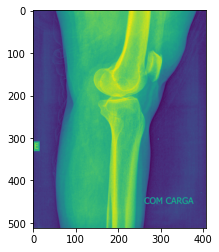

In [14]:
img2=image.imread(r"/content/gdrive/MyDrive/Colab Notebooks/images/train/1.2.826.0.1.3680043.8.498.10299385524344582994601970314833752000-c.png")
plt.imshow(img2)

In [15]:
import torch.optim as optim
from torchvision.models import resnet50
net=resnet50(weights=None)
resnet50(pretrained=False) 
# net = resNet50(22).to('cuda')

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=0.5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.1, patience=5)

In [16]:
###### Define and run your training loop here #########
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device: {}".format(device))
net.to(device)

num_epochs = 5
total_steps = len(data_loader_train)
t1 = time.time()
for epoch in range(num_epochs):
    for i, data in enumerate(data_loader_train):
        images, labels = data[0].to(device), data[1].to(device)
        # Forward pass
        outputs = net(images)
        loss = criterion(outputs, labels)
        # print("kjnfjnrnkrn",i)
        # Backprop and optimisation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # print("second time",i)
        # Train accuracy
        total = labels.size(0)
        _,predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels).sum().item()
        if (i + 1) % 10 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
                .format(epoch + 1, num_epochs, i + 1, total_steps, loss.item(),
                    (correct / total) * 100))
            
print("######## Training Finished in {} seconds ###########".format(time.time()-t1))

Device: cpu
Epoch [1/5], Step [10/59], Loss: 2.3850, Accuracy: 78.12%
Epoch [1/5], Step [20/59], Loss: 1.2241, Accuracy: 59.38%
Epoch [1/5], Step [30/59], Loss: 1.8839, Accuracy: 50.00%
Epoch [1/5], Step [40/59], Loss: 2.2764, Accuracy: 75.00%
Epoch [1/5], Step [50/59], Loss: 3.0181, Accuracy: 68.75%
Epoch [2/5], Step [10/59], Loss: 1.2731, Accuracy: 21.88%
Epoch [2/5], Step [20/59], Loss: 0.8800, Accuracy: 84.38%
Epoch [2/5], Step [30/59], Loss: 1.2895, Accuracy: 59.38%
Epoch [2/5], Step [40/59], Loss: 1.1206, Accuracy: 65.62%
Epoch [2/5], Step [50/59], Loss: 0.8618, Accuracy: 81.25%
Epoch [3/5], Step [10/59], Loss: 1.0854, Accuracy: 71.88%
Epoch [3/5], Step [20/59], Loss: 1.1108, Accuracy: 68.75%
Epoch [3/5], Step [30/59], Loss: 1.1042, Accuracy: 71.88%
Epoch [3/5], Step [40/59], Loss: 1.0185, Accuracy: 68.75%
Epoch [3/5], Step [50/59], Loss: 1.1099, Accuracy: 68.75%
Epoch [4/5], Step [10/59], Loss: 1.1666, Accuracy: 59.38%
Epoch [4/5], Step [20/59], Loss: 1.0177, Accuracy: 68.75%
Ep

In [17]:
net.eval() 
perds = []
target = []
with torch.no_grad(): 
    correct = 0
    total = 0
    for data in data_loader_test:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        perds.extend(predicted)
        target.extend(labels)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print('Test Accuracy of the model on the {} test images: {} %'
        .format(total, (correct / total) * 100))
    

Test Accuracy of the model on the 621 test images: 71.98067632850241 %


In [18]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 529 kB 5.0 MB/s 


In [19]:
from torchmetrics.functional import precision_recall
from torchmetrics import F1Score
from torchmetrics import ConfusionMatrix
perds1 = torch.stack(perds)
target1 = torch.stack(target)
f1 = F1Score(num_classes=22).to(device)
print(f1(perds1, target1))
print(precision_recall(perds1, target1, average='macro', num_classes=22))
confmat = ConfusionMatrix(num_classes=22).to(device)
confmat(perds1, target1)

tensor(0.7198)
(tensor(0.3599), tensor(0.5000))


tensor([[  0, 174,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0],
        [  0, 447,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,